## ML Review and Gradient Descent Example

In this notebook, we will solve a simple linear regression problem by gradient descent.

You will follow the typical stages of a machine learning process:

1. Load the dataset.
2. Build a multiple [linear regression](https://developers.google.com/machine-learning/glossary#linear-regression) model.
3. Evaluate the performance of the model.

## Setup

Import TensorFlow and other necessary libraries to get started:

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
print("TensorFlow version:", tf.__version__)
# Set a random seed for reproducible results
tf.random.set_seed(22)

TensorFlow version: 2.18.0


## Generate Data from a known distribution
Below we will generate data from a known distribution.  
Specifically, the true model is:

$Y = b +  X_1w_1 +X_2w_2 $

$X_1$ and $X_2$ have a uniform distribution on the interval $[0,10]$, while `b` is representing the intercept term.

We set actual values for $b$ ,$w_1$, and $w_2$

Here $b=1.5$, $w_1=2$, and $w_2=5$

We then generate a vector of $y$-values according to the model and put the predictors together in a `dataset` matrix

In [ ]:

# Set the random seed for reproducibility
tf.random.set_seed(1234)  # Equivalent to np.random.seed(1234)

num_obs = 150

# Generate random samples using TensorFlow
x1 = tf.random.uniform([num_obs], minval=0, maxval=10, dtype=tf.float32)
x2 = tf.random.uniform([num_obs], minval=0, maxval=10, dtype=tf.float32)


# Coefficients
b = 1.5
w_1 = 2.0
w_2 = 5.0

# Calculate y
y = b  + w_1 * x1 + w_2 * x2

# Stack x_mat to form a matrix with columns: [y, x1, x2]
dataset = tf.stack([y, x1, x2], axis=1)
dataset_tf = tf.convert_to_tensor(dataset, dtype=tf.float32)
# Print shape of x_mat
print(dataset_tf.shape)
print(y.shape)

(150, 3)
(150,)


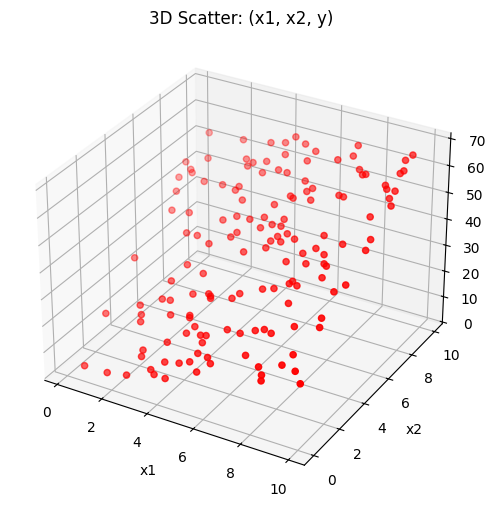

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Convert to NumPy
x1_np = x1.numpy()
x2_np = x2.numpy()
y_np  = y.numpy()

fig = plt.figure(figsize=(8,6)) # (Width, height)
ax = fig.add_subplot(111, projection='3d')
# The 111 is (1st) row, (1st) col, and the index of the plot is 1
# Ex: fig.add_subplot(222, projection='3d')
# +-------+-------+
# |  221  | (222) |
# +-------+-------+
# |  223  |  224  |
# +-------+-------+

ax.scatter(x1_np, x2_np, y_np, c='red', marker='o')
ax.set_xlabel('x1') # X
ax.set_ylabel('x2') # Y
ax.set_zlabel('y')  # Z
plt.title("3D Scatter: (x1, x2, y)")
plt.show()

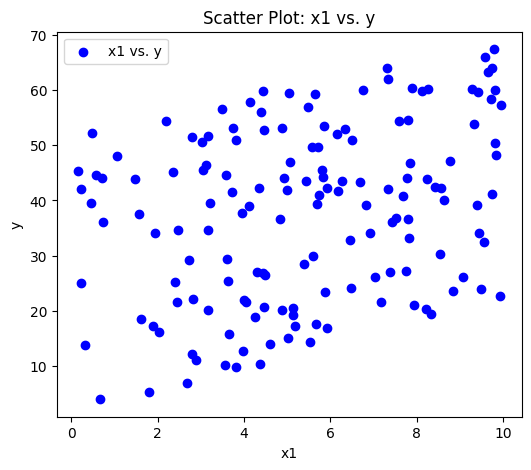

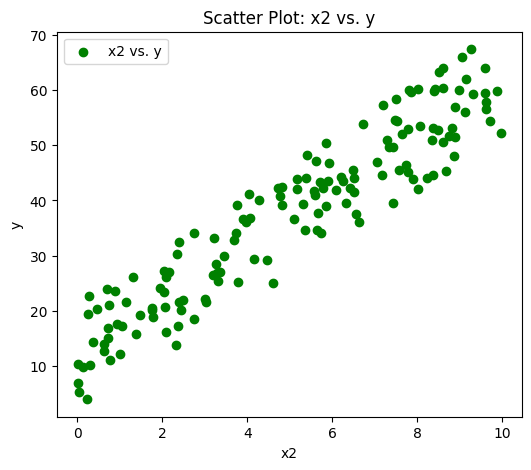

In [ ]:
x1_np = x1.numpy()
x2_np = x2.numpy()
y_np  = y.numpy()

# ---------------------------------------------------------
# 2D plot: x1 vs. y
plt.figure(figsize=(6,5))
plt.scatter(x1_np, y_np, color='blue', label='x1 vs. y')
plt.xlabel('x1')
plt.ylabel('y')
plt.title('Scatter Plot: x1 vs. y')
plt.legend() # Displays labels for plotted elements
plt.show()
# ---------------------------------------------------------
plt.figure(figsize=(6,5))
plt.scatter(x2_np, y_np, color='green', label='x2 vs. y')
plt.xlabel('x2')
plt.ylabel('y')
plt.title('Scatter Plot: x2 vs. y')
plt.legend()
plt.show()

Next, split the dataset into training and test sets. Make sure to shuffle the dataset with `tf.random.shuffle` to avoid biased splits.

In [ ]:
# Explain why
dataset_shuffled = tf.random.shuffle(dataset, seed=22)
train_data, test_data = dataset_shuffled[:125], dataset_shuffled[125:] # 20% Test
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]
print(x_train.shape)
print(y_train.shape)

(125, 2)
(125,)


## Build a machine learning model

Build a linear regression model with the TensorFlow Core APIs. The equation for multiple linear regression is as follows:

$${\mathrm{Y}} = {\mathrm{X}}w + b$$

where

* $\underset{m\times 1}{\mathrm{Y}}$: target vector
* $\underset{m\times n}{\mathrm{X}}$: feature matrix
* $\underset{n\times 1}w$: weight vector
* $b$: bias

By using the `@tf.function` decorator, the corresponding Python code is traced to generate a callable TensorFlow graph. This approach is beneficial for saving and loading the model after training. It can also provide a performance boost for models with many layers and complex operations.

In [ ]:
class LinearRegression(tf.Module):

  def __init__(self):
    self.built = False

  @tf.function
  def __call__(self, x):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weight vector and bias term
      # Shape (features, 1) === (2,1)
      # The 2 is the num of features from (125, 2) as (125, 2).shape[-1] == 2
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1])
      rand_b = tf.random.uniform(shape=[]) # Scalar (Single value) 
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Dot product X(125x2).W(2x1) = (125x1) then add b to every value
    y = tf.add(tf.matmul(x, self.w), self.b)
    return tf.squeeze(y, axis=1) # Treat it as array[1,2,3] not matrix[ [1,2,3] ]

For each example, the model returns a prediction for the input data by computing the weighted sum of its features plus a bias term. This prediction can then be unstandardized to obtain its value in terms of the original units.

In [ ]:
lin_reg = LinearRegression()
prediction = lin_reg(x_train[:1])
prediction.numpy()

array([10.493174], dtype=float32)

## Define a loss function

Now, define a loss function to evaluate the model's performance during the training process.

Since regression problems deal with continuous outputs, the mean squared error (MSE) is an ideal choice for the loss function. The MSE is defined by the following equation:

$$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i -y_i)^2$$

where

* $\hat{y}$: vector of predictions
* $y$: vector of true targets

The goal of this regression problem is to find the optimal weight vector, $w$, and bias, $b$, that minimizes the MSE loss function.

In [ ]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

## Train and evaluate your model

Using mini-batches for training provides both memory efficiency and faster convergence. The `tf.data.Dataset` API has useful functions for batching and shuffling. The API enables you to build complex input pipelines from simple, reusable pieces. Learn more about building TensorFlow input pipelines in [this guide](https://www.tensorflow.org/guide/data).

### **Effect of Changing `batch_size` in Training**
The **batch size** in machine learning and deep learning controls how many samples are processed before the model updates its parameters. The choice of **batch size = 32** is common, but adjusting it can impact **training speed, model performance, and generalization**.

---

## **1️⃣ What Happens When You Increase `batch_size`?**
If you increase `batch_size` (e.g., **64, 128, 256, 512**):
- **Pros:**
  ✅ **Faster training** (fewer updates per epoch, more parallelization on GPUs).  
  ✅ **Better hardware utilization** (efficient computation on GPUs with large memory).  
  ✅ **More stable updates** (gradient updates are averaged over a larger number of samples).  

- **Cons:**
  ❌ **Higher memory usage** (large batches require more GPU RAM).  
  ❌ **Risk of poor generalization** (large batch sizes may not capture diverse training patterns well).  
  ❌ **Slower convergence** (gradients are smaller, making updates more conservative).  

- **Use Case:**  
  🔹 Large batch sizes are useful when training on **very large datasets** with **powerful GPUs**.

---

## **2️⃣ What Happens When You Decrease `batch_size`?**
If you decrease `batch_size` (e.g., **16, 8, 4, 1**):
- **Pros:**
  ✅ **Better generalization** (more noise in gradient updates prevents overfitting).  
  ✅ **Lower memory consumption** (can train on smaller GPUs).  
  ✅ **More frequent updates** (more opportunities to adjust the weights).  

- **Cons:**
  ❌ **Slower training** (more updates per epoch → takes longer).  
  ❌ **Noisy gradients** (parameter updates fluctuate more).  
  ❌ **Less efficient on GPUs** (GPUs perform better with larger batch sizes).  

- **Use Case:**  
  🔹 Small batch sizes are useful for **limited-memory GPUs** or when **better generalization** is required.

---

## **3️⃣ What is the Ideal `batch_size`?**
The **best batch size** depends on:
- **Dataset size**: Small datasets → Smaller batch size; Large datasets → Larger batch size.
- **Hardware (GPU/TPU)**: Large GPUs handle bigger batches better.
- **Training stability**: Small batches improve generalization, large batches smooth gradients.
- **Optimization algorithm**: Some optimizers (e.g., Adam) handle small batches better than others.

### **Recommended Batch Sizes Based on Use Cases**
| Batch Size | When to Use |
|------------|------------|
| **1** | Extreme cases (e.g., Reinforcement Learning, online learning) |
| **8 - 16** | Small datasets, memory-constrained GPUs |
| **32 (default)** | Good balance of speed & generalization |
| **64 - 128** | Large datasets, powerful GPUs |
| **256+** | Extremely large datasets with TPU/GPU clusters |

### **Rule of Thumb**
- **Start with `batch_size=32`** (a balanced default).  
- **If training is slow**, increase batch size (64 or 128).  
- **If generalization is poor**, decrease batch size (16 or 8).  

Would you like to experiment with different batch sizes and compare results? 🚀

In [ ]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # Creates a dataset object from NumPy arrays or TensorFlow tensors.
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size) # Split to batches
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [ ]:
d=list(train_dataset.as_numpy_iterator())
c=0
for x_batch, y_batch in train_dataset:
  c=c+1
  print(x_batch.shape)


(32, 2)
(32, 2)
(32, 2)
(29, 2)


Next, write a training loop to iteratively update your model's parameters by making use of the MSE loss function and its gradients with respect to the input parameters.

This iterative method is referred to as [gradient descent](https://developers.google.com/machine-learning/glossary#gradient-descent). At each iteration, the model's parameters are updated by taking a step in the opposite direction of their computed gradients. The size of this step is determined by the learning rate, which is a configurable hyperparameter. Recall that the gradient of a function indicates the direction of its steepest ascent; therefore, taking a step in the opposite direction indicates the direction of steepest descent, which ultimately helps to minimize the MSE loss function.

### **Effect of Changing Learning Rate (`learning_rate = 0.01`)**
The **learning rate (`lr`)** controls how much the model's weights update during training. Choosing the right learning rate is **critical for model performance**.

---

## **🔹 1️⃣ What Happens When You Increase `learning_rate`?**
🔼 **Higher learning rates** (e.g., `0.1`, `0.5`, `1.0`):

✅ **Faster convergence** (weights update more aggressively).  
✅ **Reduces training time** (fewer iterations needed).  
❌ **Risk of overshooting** the optimal solution.  
❌ **Loss may fluctuate or diverge** (no convergence).  

### **Illustration of Large `learning_rate`**
Imagine a ball rolling down a hill (gradient descent).  
- If `lr` is too **high**, the ball **bounces around wildly** and may never settle at the lowest point.

---

## **🔻 2️⃣ What Happens When You Decrease `learning_rate`?**
🔽 **Lower learning rates** (e.g., `0.001`, `0.0001`):

✅ **More stable updates** (gradients are smaller).  
✅ **Better convergence to an optimal solution**.  
❌ **Takes much longer** to reach the minimum loss.  
❌ **May get stuck in local minima** (slow progress).  

### **Illustration of Small `learning_rate`**
- If `lr` is **too low**, the ball **rolls too slowly**, taking a very long time to reach the bottom.

---

## **🔹 3️⃣ What is the Ideal `learning_rate`?**
### ✅ **Recommended Values for Different Models**
| Model Type           | Suggested `learning_rate` |
|----------------------|-------------------------|
| Simple Linear Regression | `0.01` - `0.1` |
| Deep Neural Networks (DNN) | `0.001` - `0.01` |
| Convolutional Neural Networks (CNN) | `0.0001` - `0.01` |
| Transformers (e.g., BERT) | `0.00001` - `0.0001` |
| Reinforcement Learning | `0.0001` - `0.1` |


## **🔹 How to Choose `learning_rate`?**
- **Start with `0.01`** (default for many models).  
- **If loss is unstable, decrease it (`0.001`)**.  
- **If training is too slow, increase it (`0.05`)**.  
- **Use a scheduler** to adjust dynamically.  

In [ ]:
# Set training parameters
epochs = 100
learning_rate = 0.01
train_losses, test_losses = [], []

# Format training loop
for epoch in range(epochs):
  batch_losses_train, batch_losses_test = [], []

  # Iterate through the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = lin_reg(x_batch)
      batch_loss = mse_loss(y_pred_batch, y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, lin_reg.variables)
    for g,v in zip(grads, lin_reg.variables):
      v.assign_sub(learning_rate * g)  # Why ?!!!!!!!!!!!!!!!!!!!!! - The perfect step doesn't exist
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)

  # Iterate through the -----(testing)----- data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = lin_reg(x_batch)
    batch_loss = mse_loss(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)

  # Keep track of epoch-level model performance
  train_loss = tf.reduce_mean(batch_losses_train)
  test_loss = tf.reduce_mean(batch_losses_test)
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {train_loss.numpy():0.3f}')

# Output final losses
print(f"\nFinal train loss: {train_loss:0.3f}")
print(f"Final test loss: {test_loss:0.3f}")
#Output final values of trainable parameters
print("\nFinal parameter values:")
for i, var in enumerate(lin_reg.variables):
    print(f"  Variable {i}: {var.numpy()}")

Mean squared error for step 0: 299.503
Mean squared error for step 10: 0.078
Mean squared error for step 20: 0.062
Mean squared error for step 30: 0.051
Mean squared error for step 40: 0.041
Mean squared error for step 50: 0.034
Mean squared error for step 60: 0.028
Mean squared error for step 70: 0.024
Mean squared error for step 80: 0.019
Mean squared error for step 90: 0.016

Final train loss: 0.014
Final test loss: 0.012

Final parameter values:
  Variable 0: 1.1802641153335571
  Variable 1: [[2.0314107]
 [5.0249186]]


Plot the changes in MSE loss over time. Calculating performance metrics on a designated [validation set](https://developers.google.com/machine-learning/glossary#validation-set) or [test set](https://developers.google.com/machine-learning/glossary#test-set) ensures the model does not overfit to the training dataset and can generalize well to unseen data.

In [ ]:
lin_reg.variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.1802641153335571>,
 <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
 array([[2.0314107],
        [5.0249186]], dtype=float32)>)

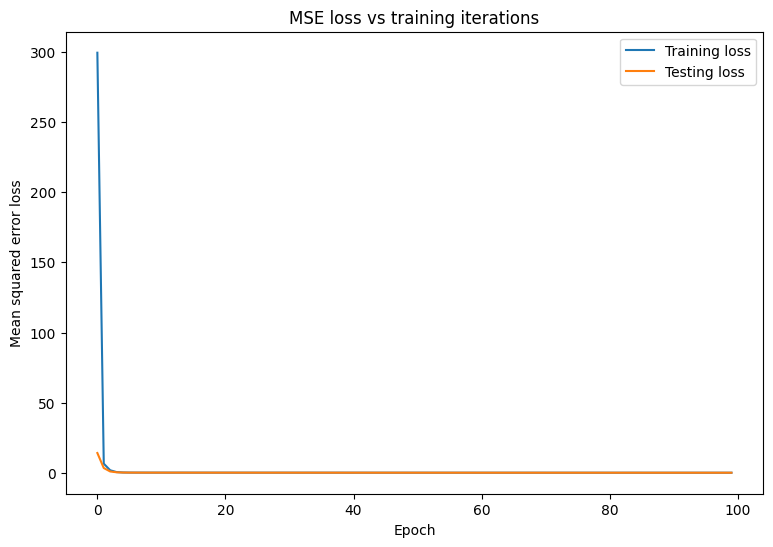

In [1]:
matplotlib.rcParams['figure.figsize'] = [9, 6]

plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error loss")
plt.legend()
plt.title("MSE loss vs training iterations");

It seems like the model does a good job of fitting the training data while also generalizing well to the unseen test data.

## Conclusion

Congratulations! You have trained a regression model using the TensorFlow Core low-level APIs.

For more examples of using TensorFlow Core APIs, check out the following guides:
* [Logistic regression](./logistic_regression_core.ipynb) for binary classification
* [Multi-layer perceptrons](./mlp_core.ipynb) for hand-written digit recognition
